# MinCUt pooling operator from the `"Mincut Pooling in Graph Neural Networks" [Paper](https://arxiv.org/abs/1907.00481)

In this noteboox, I explain the Mincut Pooling in Graph Neural Networks as far as I understand it. The notebook is based on the code [here](https://github.com/convei-lab/toptimize/blob/main/toptimize/examples/proteins_mincut_pool.py) and the amazing explaination by the authors (https://danielegrattarola.github.io/posts/2019-07-25/mincut-pooling.html)

# The PROTEINS dataset will be used
Dataset description:

    NumGraphs: 1113
    AvgNodesPerGraph: 39.06
    AvgEdgesPerGraph: 72.82
    NumFeats: 1
    NumClasses: 2


In [1]:
!pip -q install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html
!pip -q install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html
!pip -q install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html
!pip -q install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html
!pip -q install torch-geometric

# Import and prepare the data

In [2]:
from math import ceil
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader

dataset = TUDataset('./', name='PROTEINS').shuffle()
average_nodes = int(dataset.data.x.size(0) / len(dataset))
n = (len(dataset) + 9) // 10
test_dataset = dataset[:n]
val_dataset = dataset[n:2 * n]
train_dataset = dataset[2 * n:]
test_loader = DataLoader(test_dataset, batch_size=20)
val_loader = DataLoader(val_dataset, batch_size=20)
train_loader = DataLoader(train_dataset, batch_size=20)


Extracting ./PROTEINS/PROTEINS.zip
Processing...
Done!


# Writing the model

First of all we will preview the input and output of the method, then discuss the method itself.

# Input
    x (Tensor) – Node feature tensor 𝐗∈ℝ𝐵×𝑁×𝐹 with:
        batch-size 𝐵, (maximum) number of nodes 𝑁 for each graph, and feature dimension 𝐹
    adj (Tensor) – Symmetrically normalized adjacency tensor 𝐀∈ℝ𝐵×𝑁×𝑁
    s (Tensor) – Assignment tensor 𝐒∈ℝ𝐵×𝑁×𝐶 with number of clusters 𝐶.
    mask (BoolTensor, optional) – Mask matrix 𝐌∈{0,1}𝐵×𝑁 indicating the valid nodes for each graph. (default: None)

# Output
    out (Tensor)
    out_adj (Tensor)
    mincut_loss (Tensor)
    ortho_loss (Tensor)

## Step 1 -> Map nodes to clusters
We assign each node a vector of length k (k is the number of clusters),This creates "S" a matrix of (Cluster, Node) shape. To get the probability that a node belongs to any cluster, we simply apply softmax on its vector. However, the softmax part can be ignored, if we are using the clustering as an internal step (unsupervised part) of a bigger model. Or, we can use it if we are interested in the clusters. The layer is very simple just map the feature vector of each node using a linear layer. 
The code is simple:

    num_of_centers =  20
    self.pool1 = Linear(hidden_channels, num_of_centers)

The equation is simple:

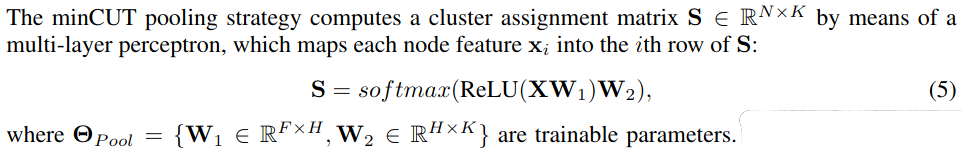


## Step 2 -> We apply two losses to improve the clustering, the first one is MinCUT loss

The authors describe it as :

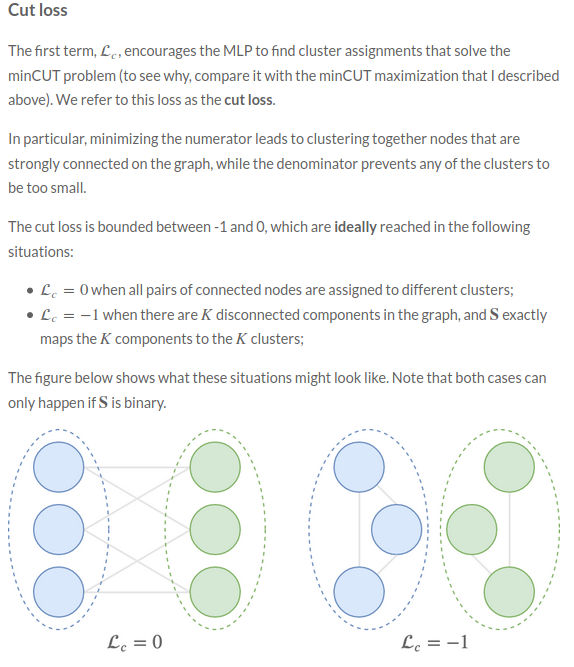


The code is 

    mincut_num = _rank3_trace(out_adj) # mincut_num torch.Size([1]) sum over all graph
    d_flat = torch.einsum('ijk->ij', adj) # torch.Size([1,266]) 
    d = _rank3_diag(d_flat) # d torch.Size([1, 266, 266]) 
    mincut_den = _rank3_trace(
        torch.matmul(torch.matmul(s.transpose(1, 2), d), s)) #[1,20,266]*[1,266,266]->[1,20,266]*[1,266,20]->[1,20,20]->[1]
    
    mincut_loss = -(mincut_num / mincut_den)
    mincut_loss = torch.mean(mincut_loss)

The equation is
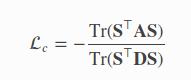

## Step 3 -> The Orthogonality loss

The authors describe it as :

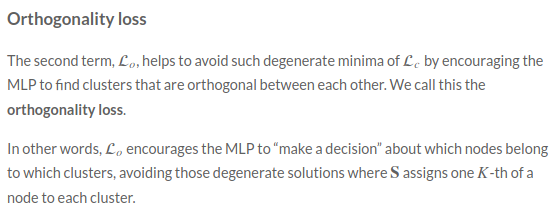

The code:

    # Orthogonality regularization.
    ss = torch.matmul(s.transpose(1, 2), s)  #[1,20,266]*[1,266,20]->[1, 20,20]
    i_s = torch.eye(k).type_as(ss) #([20, 20]) or ([10, 10])
    ortho_loss = torch.norm(
        ss / torch.norm(ss, dim=(-1, -2), keepdim=True) -
        i_s / torch.norm(i_s), dim=(-1, -2))  
    ortho_loss = torch.mean(ortho_loss)
    
The equation:
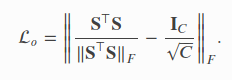

In [3]:
#Graph Convolutional Network layer where the graph structure is given by an adjacency matrix. 
#We recommend user to use this module when applying graph convolution on dense graphs.
from torch_geometric.nn import GCNConv, DenseGraphConv

from torch_geometric.utils import to_dense_batch, to_dense_adj
EPS = 1e-15

In [4]:
def dense_mincut_pool(x, adj, s, mask=None): # x torch.Size([1, 226, 32])
    x = x.unsqueeze(0) if x.dim() == 2 else x # x torch.Size([1, 226, 32])  

    adj = adj.unsqueeze(0) if adj.dim() == 2 else adj # torch.Size([1, 226, 226]) 
    s = s.unsqueeze(0) if s.dim() == 2 else s # torch.Size([1, 226, 20]) # Number of nodes

    (batch_size, num_nodes, _), k = x.size(), s.size(-1)
    s = torch.softmax(s, dim=-1) # torch.Size([1, 226, 20])

    if mask is not None: # None for now
        mask = mask.view(batch_size, num_nodes, 1).to(x.dtype)
        x, s = x * mask, s * mask

    out = torch.matmul(s.transpose(1, 2), x)  # [1, 20, 226] * [1, 226, 32] will yield [1, 20, 32]
    out_adj = torch.matmul(torch.matmul(s.transpose(1, 2), adj), s) #[1,20,226]*[1,226,226]->[1,20,266]*[1,266,20]->[1, 20, 20]

    # MinCUT regularization.
    mincut_num = _rank3_trace(out_adj) # mincut_num torch.Size([1]) sum over all graph
    d_flat = torch.einsum('ijk->ij', adj) # torch.Size([1,266]) 
    d = _rank3_diag(d_flat) # d torch.Size([1, 266, 266]) 
    mincut_den = _rank3_trace(
        torch.matmul(torch.matmul(s.transpose(1, 2), d), s)) #[1,20,266]*[1,266,266]->[1,20,266]*[1,266,20]->[1,20,20]->[1]
    
    mincut_loss = -(mincut_num / mincut_den)
    mincut_loss = torch.mean(mincut_loss)
    
    # Orthogonality regularization.
    ss = torch.matmul(s.transpose(1, 2), s)  #[1,20,266]*[1,266,20]->[1, 20,20]
    i_s = torch.eye(k).type_as(ss) #([20, 20]) or ([10, 10])
    ortho_loss = torch.norm(
        ss / torch.norm(ss, dim=(-1, -2), keepdim=True) -
        i_s / torch.norm(i_s), dim=(-1, -2))  
    ortho_loss = torch.mean(ortho_loss)
    
    # Fix and normalize coarsened adjacency matrix.
    ind = torch.arange(k, device=out_adj.device) # range e.g. from 0 to 19
    out_adj[:, ind, ind] = 0 # [1, 20, 20]  the diagnoal will be 0

    d = torch.einsum('ijk->ij', out_adj) #d torch.Size([1, 20])
    d = torch.sqrt(d)[:, None] + EPS # d torch.Size([1, 1, 20])
    #print( (out_adj / d).shape)  torch.Size([20, 20, 20]) torch.Size([20, 10, 10])
    out_adj = (out_adj / d) / d.transpose(1, 2) # ([1,20,20] / [1,1,20] ) -> [1,20,20]/[1,20,1]->[1,20,20]
    # out_adj torch.Size([20, 20, 20]) out_adj torch.Size([20, 10, 10])
    return out, out_adj, mincut_loss, ortho_loss # [20, 20, 32 # number of features],  [20, 20, 20], 1,1 


def _rank3_trace(x):
    return torch.einsum('ijj->i', x)


def _rank3_diag(x):
    eye = torch.eye(x.size(1)).type_as(x) # Returns a 2-D tensor with ones on the diagonal and zeros elsewhere.
    out = eye * x.unsqueeze(2).expand(*x.size(), x.size(1)) 
    return out

## to_dense_batch(x, batch)

    Given a sparse batch of node features 𝐗∈ℝ(𝑁1+…+𝑁𝐵)×𝐹 (with 𝑁𝑖 indicating the number of nodes in graph 𝑖), 
        # it creates a dense node feature tensor 𝐗∈ℝ𝐵×𝑁max×𝐹 (with 𝑁max=max𝐵𝑖𝑁𝑖). In addition, a second tensor holding [𝑁1,…,𝑁𝐵]∈ℕ𝐵 is returned.
        
## to_dense_adj(edge_index, batch)
    
    Converts batched sparse adjacency matrices given by edge indices and edge attributes to a single dense batched adjacency matrix.


In [5]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=32):
        super(Net, self).__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        num_of_centers =  20
        self.pool1 = Linear(hidden_channels, num_of_centers) # The degree of the node belonging to any of the centers
        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)

        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch): # x torch.Size([661, 3]),  data.batch  torch.Size([783])
        x = F.relu(self.conv1(x, edge_index))  #x torch.Size([661, 32])
        x, mask = to_dense_batch(x, batch) #now x torch.Size([1, 661, 32]) ; mask torch.Size([20, 122])
        adj = to_dense_adj(edge_index, batch) # adj torch.Size([1, 661, 661])
        s = self.pool1(x) # s torch.Size([1, 661, 20])
        x, adj, mincut_loss, ortho_loss = dense_mincut_pool(x, adj, s, mask) # x torch.Size([1, 20, 32]),  adj torch.Size([1, 20, 20])
        x = self.conv2(x, adj) #x torch.Size([1, 20, 32])
        x = x.mean(dim=1) # x torch.Size([1, 32])
        x = F.relu(self.lin1(x)) # x torch.Size([1, 32])
        x = self.lin2(x) #x torch.Size([1, 2])
        return F.log_softmax(x, dim=-1), mincut_loss , ortho_loss 

# Train and test the model as always

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)


def train(epoch):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, mc_loss, o_loss = model(data.x, data.edge_index, data.batch) # data.batch  torch.Size([783])
        loss = F.nll_loss(out, data.y.view(-1)) + mc_loss + o_loss
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0

    for data in loader:
        data = data.to(device)
        pred, mc_loss, o_loss = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(pred, data.y.view(-1)) + mc_loss + o_loss
        correct += pred.max(dim=1)[1].eq(data.y.view(-1)).sum().item()

    return loss, correct / len(loader.dataset)


best_val_acc = test_acc = 0
best_val_loss = float('inf')
patience = start_patience = 50
for epoch in range(1, 15):
    train_loss = train(epoch)
    _, train_acc = test(train_loader)
    val_loss, val_acc = test(val_loader)
    if val_loss < best_val_loss:
        test_loss, test_acc = test(test_loader)
        best_val_acc = val_acc
        patience = start_patience
    else:
        patience -= 1
        if patience == 0:
            break
    print('Epoch: {:03d}, '
          'Train Loss: {:.3f}, Train Acc: {:.3f}, '
          'Val Loss: {:.3f}, Val Acc: {:.3f}, '
          'Test Loss: {:.3f}, Test Acc: {:.3f}'.format(epoch, train_loss,
                                                       train_acc, val_loss,
                                                       val_acc, test_loss,
                                                       test_acc))

Epoch: 001, Train Loss: 0.893, Train Acc: 0.586, Val Loss: 0.663, Val Acc: 0.634, Test Loss: 0.835, Test Acc: 0.634
Epoch: 002, Train Loss: 0.858, Train Acc: 0.661, Val Loss: 0.640, Val Acc: 0.670, Test Loss: 0.794, Test Acc: 0.732
Epoch: 003, Train Loss: 0.846, Train Acc: 0.714, Val Loss: 0.637, Val Acc: 0.732, Test Loss: 0.762, Test Acc: 0.777
Epoch: 004, Train Loss: 0.836, Train Acc: 0.728, Val Loss: 0.633, Val Acc: 0.705, Test Loss: 0.733, Test Acc: 0.804
Epoch: 005, Train Loss: 0.828, Train Acc: 0.735, Val Loss: 0.630, Val Acc: 0.723, Test Loss: 0.708, Test Acc: 0.821
Epoch: 006, Train Loss: 0.821, Train Acc: 0.738, Val Loss: 0.633, Val Acc: 0.732, Test Loss: 0.694, Test Acc: 0.821
Epoch: 007, Train Loss: 0.815, Train Acc: 0.733, Val Loss: 0.635, Val Acc: 0.714, Test Loss: 0.685, Test Acc: 0.821
Epoch: 008, Train Loss: 0.810, Train Acc: 0.735, Val Loss: 0.637, Val Acc: 0.714, Test Loss: 0.681, Test Acc: 0.821
Epoch: 009, Train Loss: 0.805, Train Acc: 0.731, Val Loss: 0.640, Val Ac